# Scipy 2024 poster demos

This notebook holds and executes source code for the accompanying poster for Scipy 2024: "From concept to compute: accelerating research with workflow management in `pyiron`". The code on the poster is abridged in some places and results are stochastic (e.g. the "Learning" section depends directly on `random.random`), but this notebook was used directly to generate poster content.

# Learning

A self-contained toy example demonstrating the key functionality of `pyiron_workflow`. Cf. the poster for links between code and philosophy.

In [1]:
import pickle
from random import random
from time import sleep, time

from pyiron_workflow import Workflow


@Workflow.wrap.as_function_node("seconds", "minutes", "hours")
def Sleep(sleep_seconds: float | int) -> tuple[float, float, float]:
    sleep(sleep_seconds)
    return float(sleep_seconds), sleep_seconds / 60., sleep_seconds / 3600.


@Workflow.wrap.as_macro_node()
def NextStep(self, existing: list | None, new_element, max_step):
    self.history = Workflow.create.standard.AppendToList(
        existing=existing,
        new_element=new_element,
    )
    self.random = Workflow.create.standard.PureCall(random)
    self.next_step = self.history[-1] + max_step * self.random
    return self.history, self.next_step


@Workflow.wrap.as_macro_node("increasing")
def StochasticProgress(
    self,
    start: int | float = 0,
    end: int | float = 3.13,
    step_scale: int | float = 1.0,
) -> list[float]:
    self.body = NextStep(None, start, step_scale)
    self.body.inputs.existing = self.body.outputs.history
    self.body.inputs.new_element = self.body.outputs.next_step

    self.condition = self.body.outputs.next_step < end
    self.control = Workflow.create.standard.If(condition=self.condition)

    self.starting_nodes = [self.body]
    self.body >> self.condition >> self.control
    self.control.signals.output.true >> self.body

    return self.body.outputs.history


wf = Workflow("demo")

wf.wait_times = StochasticProgress()
wf.wait = Workflow.create.for_node(
    body_node_class=Sleep,
    iter_on=("sleep_seconds",),
    sleep_seconds=wf.wait_times
)

t0 = time()
with Workflow.create.ThreadPoolExecutor(max_workers=8) as exe:
    wf.wait.body_node_executor = exe
    wf()
t1 = time()

print(
    f"Body node sleep times "
    f"{[round(t, 2) for t in wf.wait_times.outputs.increasing.value]}s"
)
print(f"Total runtime {(t1 - t0):.2f}s")
print(
    "Loop body node execution provenance",
    [l.replace("body_", "") for l in wf.wait.provenance_by_execution if "body" in l]
)
print(
    "Loop body node completion provenance",
    [l.replace("body_", "") for l in wf.wait.provenance_by_completion if "body" in l]
)

wf.draw(depth=1).render("figures/workflow", format="eps")
wf.wait_times.draw().render("figures/while_macro", format="eps")

reloaded = pickle.loads(pickle.dumps(wf))
print(all(reloaded.wait.outputs.df.value == wf.wait.outputs.df.value))


Body node sleep times [0, 0.67, 1.18, 2.06, 2.6, 3.08]s
Total runtime 3.27s
Loop body node execution provenance ['5', '4', '3', '2', '1', '0']
Loop body node completion provenance ['0', '1', '2', '3', '4', '5']
True


# Doing

A materials science example that, although using simplified input parameters (e.g. terribly relaxed convergence criterion), otherwise borders on being a real research use case. The overall objective is to identify solutes which bind strongly to vacancies, and ultimately assess the most promising candidate with an expensive density functional theory (DFT) calculation. The workflow proceeds in three stages: 
- Converge the system size using a simple model
- Scan a variety of solutes with an inexpensive classical model
- Starting from a classically pre-relaxed structure, asses DFT binding energy of the most promising candidate

This workflow also leverages most of the key features of `pyiron_workflow`; the latter two steps here leverage independent file-base executables, demonstrating how the framework can interact with a wide variety of tools. In this case, IO parsing (and other operations) are all done using the `ase` library (not affiliated), and a set of nodes is provided that wrap a subset of that library. This package was chosen instead of one of pyiron's atomistics packages to demonstrate the flexibility of `pyiron_workflow` and to provide the interested reader with a pedagogical example of wrapping a very OOP-based library into a "functional" paradigm. A more complete wrapping would benefit from further abstractions, e.g. additional data classes to package IO, a layer of universal nodes caring for unit conversions between different calculators, etc., but the provided node package is plenty to show how to get the ball rolling.

There are two technical points: First, the penultimate layer of nodes specific to this exact workflow are separated into their own `.py` file so that a `concurrent.futures.ProcessPoolExecutor` can be leveraged -- this executor needs to be able to import the nodes in its various processes and simply can't if they're defined here in the notebook's `__main__`. Second, many of the macros leverage the `parent` kwarg so that they have access to their parent node _at instantiation_ (otherwise they would not get parented until they're used in attribute assignment); this is because we leverage the semantic node path to specify file locations for file-based operations at instantiation -- this works robustly but the UX would benefit from some improvements here.

In [1]:
from ase import Atoms
from pyiron_workflow import Workflow

import ase_nodes as an
import my_nodes as mn

In [2]:
@Workflow.wrap.as_macro_node("repeats", "supercell")
def SizeConverged(
    self,
    host: str,
    solutes: list[str],
    optimizer: an.optimizers.DelayedOptimizer,
    filter_: an.filters.DelayedFilter,
    cubic_host: bool = True
) -> tuple[int, Atoms]:
    """Find the largest solute based on ASE's guess of the per-atom volume."""
    self.biggest_solute = mn.BiggestSpeciesGuess(species=solutes)
    self.unit = an.atoms.Bulk(host, cubic=cubic_host)
    self.cheap_calculator = an.calculators.EMT()
    self.converged_repeats = mn.IncreaseSizeWhileEnergyChanges(
        host_unit_cell=self.unit,
        solute=self.biggest_solute,
        calculator=self.cheap_calculator,
        optimizer=optimizer,
        filter_=filter_,
        parent=self,
        energy_threshold=0.001  # Intentionally "large" for the sake of speed
    )
    self.supercell = an.atoms.Repeat(self.unit, self.converged_repeats)
    return self.converged_repeats, self.supercell

@Workflow.wrap.as_macro_node()
def ScanCandidates(
    self,
    supercell: Atoms,
    solutes: list[str],
    optimizer: an.optimizers.DelayedOptimizer,
    filter_: an.filters.DelayedFilter,
) -> tuple[str, list[Atoms]]:
    """
    Scan the solute-vacancy binding energies and return classically-relaxed structures
    for the strongest-binding solute.
    
    The automated behaviour of the lammps calculator is composition-dependent -- before 
    starting the binding calculation, we need to set the potential in stone! So iterate 
    on `LAMMPSSoluteVacancyBinding` instead of `SoluteVacancyBinding`
    """
    self.binding_energies = Workflow.create.for_node(
        mn.LAMMPSSoluteVacancyBinding,
        iter_on=("solute",),
        bulk=supercell,
        solute=solutes,
        optimizer=optimizer,
        filter_=filter_,
        parent=self,  # So the semantic path is available at instantiate for file paths
    )

    self.strongest_solute = self.binding_energies.outputs.df["solute"][
        Workflow.create.standard.PureCall(
            self.binding_energies.outputs.df["binding_energy"].idxmin, parent=self
        )
    ]

    self.is_strongest = Workflow.create.standard.Equals(
        self.binding_energies.outputs.df["solute"],
        self.strongest_solute
    )
    self.relaxed = self.binding_energies.outputs.df["atoms"][self.is_strongest].iloc[0]
    return self.strongest_solute, self.relaxed

@Workflow.wrap.as_macro_node("energy")
def DFTBinding(
    self,
    binding_structures: list[Atoms],
    optimizer: an.optimizers.DelayedOptimizer,
    filter_: an.filters.DelayedFilter,
) -> float:
    """
    Use DFT to evaluate a final binding energy.

    The macro is used here to hard-code the calculator and various input parameters 
    for a cheap calculation, but these could instead be exposed as macro input.
    """
    self.expensive_calculator = an.calculators.Espresso(
        input_data={
            "tstress": True,
            "electron_maxstep": 1,
            "scf_must_converge": False,
        },  # Just the cheap parameters -- this is a demo on a laptop, not real science
        n_cores=4,
        oversubscribe=True,
    )
    self.dft_binding = an.physics.BindingEnergy(
        a=binding_structures[0],
        b=binding_structures[1],
        ab=binding_structures[2],
        neither=binding_structures[3],
        calculator=self.expensive_calculator,
        optimizer=optimizer,
        minimize_input=an.physics.MinimizeInput(steps=0),  # Again, be cheap not right
        filter_=filter_,
        parent=self,  # So the semantic path is available at instantiate for file paths
    )
    return self.dft_binding.outputs.binding_energy

In [3]:
wf = Workflow("binding_example")

wf.host = Workflow.create.standard.UserInput("Al")
wf.host.inputs.user_input.type_hint = str

wf.solutes = Workflow.create.standard.UserInput(["Cu", "Au", "Ni", "Pd", "Pt"])
wf.solutes.inputs.user_input.type_hint = list[str]

wf.optimizer = an.optimizers.BFGS()  # For ionic relaxation
wf.filter = an.filters.UnitCellFilter()  # For cell relaxation

wf.converged = SizeConverged(
    host=wf.host,
    solutes=wf.solutes,
    optimizer=wf.optimizer,
    filter_=wf.filter
)

wf.scanned = ScanCandidates(
    supercell=wf.converged.outputs.supercell, 
    solutes=wf.solutes,
    optimizer=wf.optimizer,
    filter_=wf.filter
)

wf.dft_binding = DFTBinding(
    binding_structures=wf.scanned.outputs.relaxed,
    optimizer=wf.optimizer,
    filter_=wf.filter
)

In [9]:
with Workflow.create.ProcessPoolExecutor(max_workers=4) as exe:
    wf.scanned.binding_energies.body_node_executor = exe
    wf()

      Step     Time          Energy          fmax
BFGS:    0 11:50:06       -0.162221        0.161794
BFGS:    1 11:50:06       -0.163342        0.161552
BFGS:    2 11:50:06       -0.253965        0.140488
BFGS:    3 11:50:06       -0.331882        0.119195
BFGS:    4 11:50:06       -0.396954        0.097676
BFGS:    5 11:50:06       -0.449048        0.075933
BFGS:    6 11:50:06       -0.488030        0.053971
BFGS:    7 11:50:07       -0.513771        0.031797
BFGS:    8 11:50:07       -0.526146        0.009422
      Step     Time          Energy          fmax
BFGS:    0 11:50:07        0.718668        0.159238
BFGS:    1 11:50:07        0.716468        0.159106
BFGS:    2 11:50:07        0.675671        0.152686
BFGS:    3 11:50:07        0.673136        0.152095
BFGS:    4 11:50:07        0.596820        0.130613
BFGS:    5 11:50:08        0.563283        0.108251
BFGS:    6 11:50:08        0.556945        0.120652
BFGS:    7 11:50:08        0.529478        0.141994
BFGS:    8 11:50

In [10]:
wf.outputs.to_value_dict()

{'converged__converged_repeats': 3,
 'scanned__strongest_solute': 'Pt',
 'dft_binding__binding_energy': -0.09048996041383361}

Although not part of the workflow output, users can always dig in and look at the internal state of the workflow. E.g., we can peek at the full results table from our classical binding energy scan across solutes:

In [11]:
wf.scanned.binding_energies.outputs.df.value

,solute,binding_energy,data,atoms
0,Cu,0.040976,[AtomicOutput(potential_energy=-363.1191972292...,"[(Atom('Al', [-1.4196333992568104e-13, 0.04988..."
1,Au,0.102845,[AtomicOutput(potential_energy=-366.2905701480...,"[(Atom('Al', [-1.1070936566678623e-13, -0.0022..."
2,Ni,-0.073453,[AtomicOutput(potential_energy=-364.8711746626...,"[(Atom('Al', [-1.0655305688335367e-13, 0.08474..."
3,Pd,0.025771,[AtomicOutput(potential_energy=-405.4564246062...,"[(Atom('Al', [-6.565739893310624e-14, 0.071756..."
4,Pt,-0.170689,[AtomicOutput(potential_energy=-367.0094566971...,"[(Atom('Al', [-1.2389777143076699e-13, 0.05543..."


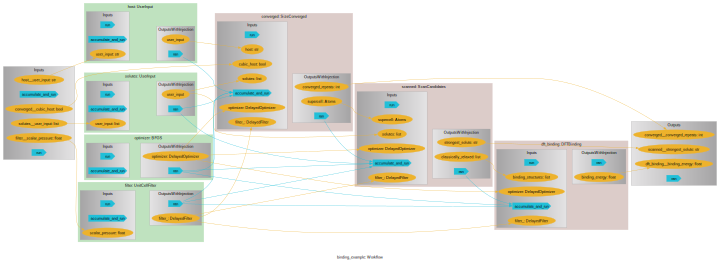

In [12]:
wf.draw(size=(10,10))

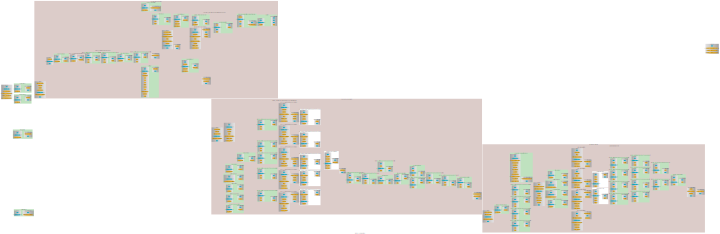

In [17]:
wf.draw(size=(10, 10), depth=3)

In [18]:
wf.draw().render("figures/doing", format="eps")
wf.draw(depth=3, size=(10,10)).render("figures/doing_depth", format="eps")

'figures/doing_depth.eps'